# Generating Songs Using an LSTM from Genius Lyrics
Data collection info here ---> https://github.com/johnwmillr/LyricsGenius

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import json
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
from LSTM import *

# Check if your system supports CUDA
torch.manual_seed(42069)
np.random.seed(42069)
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [2]:
dataset = loader('Lyrics_ChiefKeef.json', with_tags=True)
batch_size = 1

In [3]:
print(dataset.songs[0])

<start>
Title: Love Sosa
[Spoken Intro: Jordan Gilty]
Fuckers in school telling me, always in the barber shop
"Chief Keef ain't 'bout this, Chief Keef ain't 'bout that
My boy a BD on fucking Lamron and them
He, he, they say that nigga don't be putting in no work”
Shut the fuck up!
Y'all niggas ain’t know shit!
All ya motherfuckers talk about...
“Chief Keef ain't no hitta, Chief Keef ain't this, Chief Keef a fake”
Shut the fuck up!
Y'all don't real with that nigga!
Y'all know that nigga got caught with a ratchet
Shootin' at the police and shit
Nigga been on probation since, fuckin', I don't know when!
Motherfucka, stop fuckin' playin' him like that
Them niggas savages out there!
If I catch another motherfucker talking sweet about Chief Keef
I'm fucking beating they ass!
I'm not fucking playing no more!
Y'know them niggas roll with Lil Reese and them
(Young Chop on the beat)

[Chorus]
These bitches love Sosa
O End or no end
Fuckin' with them O boys
You gon' get fucked over
Raris and Rove

# Train Validation Splits

In [4]:
validation_split = .2
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(42069)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

# LSTM Architecture

In [5]:
input_dim = len(dataset.char_dict)
hidden_dim = 300
n_layers = 3
batch_size = 1

model = Nnet(input_dim, hidden_dim, n_layers, dropout=0.25)
model.to(device)

Nnet(
  (lstm_layer): LSTM(109, 300, num_layers=3, dropout=0.25)
  (fc): Linear(in_features=300, out_features=109, bias=True)
)

# Loss Functions and Optimizer

In [6]:
#loss criteria are defined in the torch.nn package
criterion = nn.CrossEntropyLoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

# Training Process

In [7]:
epochs = 200
clip = 10
chunk_len = 300
early_stop = True
early_stop_thresh = 15
valid_loss_min = np.Inf

val_losses_epoch = []
train_losses_epoch = []

def get_labels(inputs):
    labels = torch.zeros(inputs.shape[0])

    for i,oneHot in enumerate(inputs[1:]):
        idx = oneHot.argmax().item()
        labels[i] = idx
        
    return labels


index_to_char = {v: k for k, v in dataset.char_dict.items()}

model.train()
print("Training...")
for epoch in range(epochs):
    # training process
    for sample_idx, song in enumerate(train_loader):
        h = model.init_hidden(batch_size)
        song_chunks = chunkstring(song[0], chunk_len)
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            model.zero_grad()
            output, h = model(inputs, h)
            loss = criterion(output, labels)
            h = tuple([e.detach() for e in h])
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        
        
    # validation process
    val_losses = []
    model.eval()
    #print("Evaluating on validation set...")
    for sample_idx, song in enumerate(val_loader):
#         if sample_idx % 100 == 0:
#             print("Evaluating on song %d (%d/%d)"  % (sample_idx, sample_idx, len(val_loader)))
        val_h = model.init_hidden(batch_size)
        val_h = tuple([each.data for each in val_h])
        song_chunks = chunkstring(song[0], chunk_len)
        
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)
            val_losses.append(val_loss.item())
        
    # evaluate on the training set to get training loss metrics
    train_losses = []
    #print("Evaluting on training set...")
    for sample_idx, song in enumerate(train_loader):
        h = model.init_hidden(batch_size)
        song_chunks = chunkstring(song[0], chunk_len)
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            output, h = model(inputs, h)
            train_loss = criterion(output, labels)
            train_losses.append(train_loss.item())
    
    
    train_losses_epoch.append(np.mean(train_losses))
    val_losses_epoch.append(np.mean(val_losses))

    model.train()
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "Training Loss: {:.6f}...".format(np.mean(train_losses)),
          "Validation Loss: {:.6f}".format(np.mean(val_losses)))
    
    if epoch % 5 == 0:
        print('Creating training checkpoint...')
        # save training progress every five epochs
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, 'chief_keef_state_ckpt.pth')
    
    if val_losses_epoch[epoch] <= valid_loss_min:
        torch.save(model.state_dict(), './chief_keef_state_dict.pth')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)
        
        if early_stop:
            early_stop_strikes = 0
    
    else:
        if early_stop:
            early_stop_strikes += 1
            if early_stop_strikes >= early_stop_thresh:
                print("Early stopping is enabled. Training will now stop.")
                break
            else:
                print("Early stopping is enabled. Training will stop in %d epochs if validation loss does not go down."
                    % (early_stop_thresh-early_stop_strikes))

Training...
Epoch: 1/200... Training Loss: 2.882576... Validation Loss: 2.884686
Creating training checkpoint...
Validation loss decreased (inf --> 2.884686).  Saving model ...
Epoch: 2/200... Training Loss: 2.367019... Validation Loss: 2.373746
Validation loss decreased (2.884686 --> 2.373746).  Saving model ...
Epoch: 3/200... Training Loss: 2.112025... Validation Loss: 2.123197
Validation loss decreased (2.373746 --> 2.123197).  Saving model ...
Epoch: 4/200... Training Loss: 1.956554... Validation Loss: 1.973575
Validation loss decreased (2.123197 --> 1.973575).  Saving model ...
Epoch: 5/200... Training Loss: 1.831218... Validation Loss: 1.851661
Validation loss decreased (1.973575 --> 1.851661).  Saving model ...
Epoch: 6/200... Training Loss: 1.747443... Validation Loss: 1.774888
Creating training checkpoint...
Validation loss decreased (1.851661 --> 1.774888).  Saving model ...
Epoch: 7/200... Training Loss: 1.689199... Validation Loss: 1.719967
Validation loss decreased (1.774

Epoch: 55/200... Training Loss: 0.955004... Validation Loss: 1.329481
Early stopping is enabled. Training will stop in 8 epochs if validation loss does not go down.
Epoch: 56/200... Training Loss: 0.947673... Validation Loss: 1.332330
Creating training checkpoint...
Early stopping is enabled. Training will stop in 7 epochs if validation loss does not go down.
Epoch: 57/200... Training Loss: 0.942351... Validation Loss: 1.332994
Early stopping is enabled. Training will stop in 6 epochs if validation loss does not go down.
Epoch: 58/200... Training Loss: 0.935965... Validation Loss: 1.330512
Early stopping is enabled. Training will stop in 5 epochs if validation loss does not go down.
Epoch: 59/200... Training Loss: 0.930279... Validation Loss: 1.331598
Early stopping is enabled. Training will stop in 4 epochs if validation loss does not go down.
Epoch: 60/200... Training Loss: 0.924119... Validation Loss: 1.329083
Validation loss decreased (1.329243 --> 1.329083).  Saving model ...
Epoc

# Loss Curves

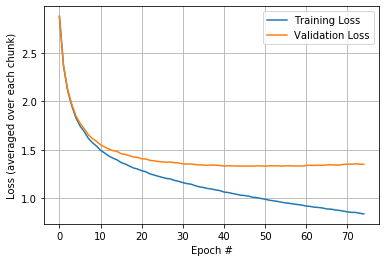

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(train_losses_epoch)
plt.plot(val_losses_epoch)
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.xlabel('Epoch #')
plt.ylabel('Loss (averaged over each chunk)')
plt.show()

# Generating Lyrics

In [16]:
from torch.nn.functional import softmax
from torch.distributions.categorical import Categorical
from copy import deepcopy


model = Nnet(input_dim, hidden_dim, n_layers, dropout=0.25)
model.load_state_dict(torch.load('chief_keef_state_dict.pth'))
model.to(device)
model.eval()


def get_next_char(model, char_dict, hidden, input_token='<start>', sampling_scheme='softmax', temperature=0.7):
    '''Gets the next character given a chunk input_token
    :param: a pytorch neural network to be passed
    :char_dict: a dictionary mapping alphanumeric characters of type str to integers
    :input_token: the string to begin on for the LSTM
    '''
    inputs = encode_chunk(input_token, char_dict)
    h = tuple([e.data for e in hidden])
    inputs = inputs.to(device)

    output, h = model(inputs, h)

    if sampling_scheme == 'softmax':
        prediction_vector = softmax(output / temperature, dim=1)
        output_dist = Categorical(probs=prediction_vector)
        next_char = output_dist.sample()[-1]
    else:
        # argmax sampling scheme
        prediction_vector = softmax(output, dim=1)
        next_char = prediction_vector.argmax(dim=1)[-1]
    
    return next_char, h

In [18]:
generated_file_size = 100000 # characters
model_name = 'ChiefKeef_LSTM'

next_chunk = '<start>\nTitle:'

out = deepcopy(next_chunk)
    
index_to_char = {v: k for k, v in dataset.char_dict.items()}

max_chunk_size = 300
hidden = model.init_hidden(1)
for progress,i in enumerate(range(generated_file_size)):
    if progress % 500 == 0:
        print("Generation progress: %d/%d characters" % (progress, generated_file_size))
    if progress == 0 or next_chunk[-len('<end>'):] == '<end>':
        if progress > 0:
            next_chunk = '<start>\n'
            out += '\n<start>\n'
        #hidden = model.init_hidden(1)
    
    (next_char, h) = get_next_char(model, dataset.char_dict, hidden, input_token=next_chunk)
    char = index_to_char[next_char.item()]
    
    if len(next_chunk) < max_chunk_size:
        next_chunk += char
    else:
        next_chunk = next_chunk[1:] + char
    out += char
    
with open("generated_songs/generated_songs_" + model_name + ".txt", "w") as text_file:
    print(out, file=text_file)
    
print(out)

Generation progress: 0/100000 characters
Generation progress: 500/100000 characters
Generation progress: 1000/100000 characters
Generation progress: 1500/100000 characters
Generation progress: 2000/100000 characters
Generation progress: 2500/100000 characters
Generation progress: 3000/100000 characters
Generation progress: 3500/100000 characters
Generation progress: 4000/100000 characters
Generation progress: 4500/100000 characters
Generation progress: 5000/100000 characters
Generation progress: 5500/100000 characters
Generation progress: 6000/100000 characters
Generation progress: 6500/100000 characters
Generation progress: 7000/100000 characters
Generation progress: 7500/100000 characters
Generation progress: 8000/100000 characters
Generation progress: 8500/100000 characters
Generation progress: 9000/100000 characters
Generation progress: 9500/100000 characters
Generation progress: 10000/100000 characters
Generation progress: 10500/100000 characters
Generation progress: 11000/100000 

Generation progress: 91500/100000 characters
Generation progress: 92000/100000 characters
Generation progress: 92500/100000 characters
Generation progress: 93000/100000 characters
Generation progress: 93500/100000 characters
Generation progress: 94000/100000 characters
Generation progress: 94500/100000 characters
Generation progress: 95000/100000 characters
Generation progress: 95500/100000 characters
Generation progress: 96000/100000 characters
Generation progress: 96500/100000 characters
Generation progress: 97000/100000 characters
Generation progress: 97500/100000 characters
Generation progress: 98000/100000 characters
Generation progress: 98500/100000 characters
Generation progress: 99000/100000 characters
Generation progress: 99500/100000 characters
<start>
Title: Lord Marrining
[Intro]
Zaytoven
4hunna
Catch up
<end>
<start>
Title: Let Me Catch Chief Keef
[Verse 2]
No one on the corner come three when I pull up hold up
My plug the pedet in the Streets, but I'm smoking on the car
A